<a href="https://colab.research.google.com/github/fahammed2022/Deep-Learning-Projects/blob/main/Sequential%20data%20(timeseries%20%2B%20text)%20Class%20resource%20provided%20by%20professor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CAP 6619 - Deep Learning
## Project 5
## Sequential data (timeseries + text)

## Part 1: Temperature forecasting using RNNs

Following closely along Chapter 10 of [our textbook](https://learning.oreilly.com/library/view/deep-learning-with/9781617296864),  Part 1 uses a temperature-forecasting task as a example of using DL to process and make predictions on sequential data.

Dataset: recorded at [the weather station at the Max Planck Institute for Biogeochemistry in Jena, Germany](https://www.bgc-jena.mpg.de/wetter/), it consists of 14 different quantities (such as temperature, pressure, humidity, wind direction, and so on)  recorded every 10 minutes over several years. The original data goes back to 2003, but the subset of the data we’ll download is limited to 2009–2016.

Useful sources and references for Part 1:

https://colab.research.google.com/github/fchollet/deep-learning-with-python-notebooks/blob/master/chapter10_dl-for-timeseries.ipynb


### Acquiring and inspecting the data

In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-04-07 23:17:45--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.44.166, 52.217.166.24, 54.231.204.104, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.44.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  53.8MB/s    in 0.2s    

2023-04-07 23:17:46 (53.8 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Inspecting the data**

In [ ]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Parsing the data**

In [ ]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

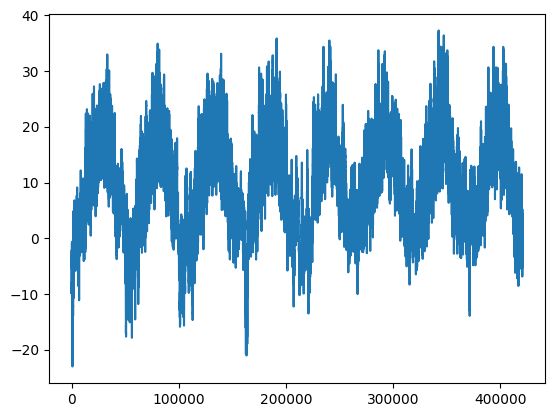

In [ ]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**

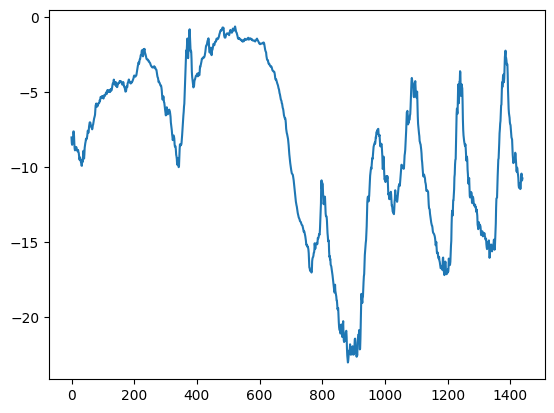

In [ ]:
plt.plot(range(1440), temperature[:1440])

**Computing the number of samples we'll use for each data split**

In [ ]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data

**Normalizing the data**

In [ ]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [ ]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing**

In [ ]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [ ]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### Building a baseline "model"

In this case we will try to predict the temperature by simply assuming that the temperature 24 hours from now will be equal to the temperature right now.

We shall use the mean absolute error (MAE) as a metric of performance and consider this (rather silly) "model" as our baseline.


**Computing the common-sense baseline MAE**

In [ ]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


### Building our *real* first model

This is essentially the "simple LSTM-based model" from Listing 10.12 in the textbook.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 133s 159ms/step - loss: 42.0037 - mae: 4.7041 - val_loss: 12.4410 - val_mae: 2.6894
Epoch 2/10
819/819 [==============================] - 151s 184ms/step - loss: 11.0687 - mae: 2.5840 - val_loss: 9.8377 - val_mae: 2.4399
Epoch 3/10
819/819 [==============================] - 137s 167ms/step - loss: 9.8310 - mae: 2.4510 - val_loss: 9.9172 - val_mae: 2.4440
Epoch 4/10
819/819 [==============================] - 136s 166ms/step - loss: 9.2879 - mae: 2.3862 - val_loss: 9.9088 - val_mae: 2.4261
Epoch 5/10
819/819 [==============================] - 137s 167ms/step - loss: 8.8541 - mae: 2.3266 - val_loss: 10.0811 - val_mae: 2.4553
Epoch 6/10
819/819 [==============================] - 137s 166ms/step - loss: 8.5324 - mae: 2.2828 - val_loss: 10.2302 - val_mae: 2.4889
Epoch 7/10
819/819 [==============================] - 135s 164ms/step - loss: 8.3365 - mae: 2.2547 - val_loss: 10.2619 - val_mae: 2.4880
Epoch 8/10
819/819 [======================

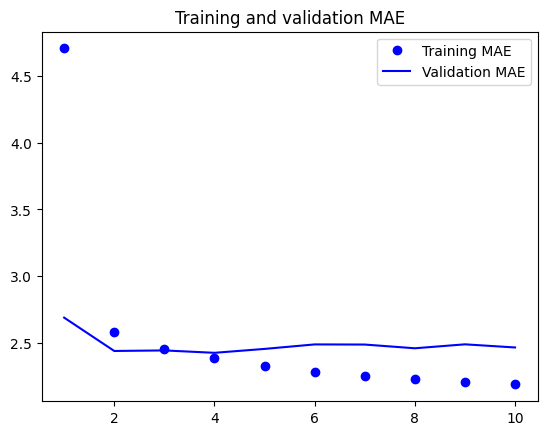

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### TODO 1: Improve the solution for temperature forecast
Write code to produce another solution to the temperature forecasting problem that outperforms the one above, i.e., has a lower Test MAE.

You can use a (combination of) different architecture (e.g., bidirectional RNN, see Listing 10.24 in the textbook), dropout and/or other regularization strategies, hyperparameter optimizations, or any other acceptable "trick" in the deep learning world.

In [ ]:
# Training and evaluating a dropout-regularized, stacked GRU model for 10 epochs

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
my_model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
my_model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = my_model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
my_model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Training MAE: {my_model.evaluate(train_dataset)[1]:.2f}")
print(f"Test MAE: {my_model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 399s 481ms/step - loss: 26.5333 - mae: 3.7856 - val_loss: 9.2297 - val_mae: 2.3443
Epoch 2/10
819/819 [==============================] - 433s 528ms/step - loss: 14.0734 - mae: 2.9087 - val_loss: 9.7608 - val_mae: 2.4360
Epoch 3/10
819/819 [==============================] - 434s 529ms/step - loss: 13.2758 - mae: 2.8264 - val_loss: 8.9298 - val_mae: 2.3197
Epoch 4/10
819/819 [==============================] - 429s 524ms/step - loss: 12.7578 - mae: 2.7703 - val_loss: 8.7799 - val_mae: 2.3018
Epoch 5/10
819/819 [==============================] - 396s 483ms/step - loss: 12.1848 - mae: 2.7050 - val_loss: 9.1715 - val_mae: 2.3489
Epoch 6/10
819/819 [==============================] - 394s 481ms/step - loss: 11.7714 - mae: 2.6622 - val_loss: 8.9866 - val_mae: 2.3374
Epoch 7/10
819/819 [==============================] - 432s 527ms/step - loss: 11.3677 - mae: 2.6143 - val_loss: 9.4691 - val_mae: 2.4024
Epoch 8/10
819/819 [=====================

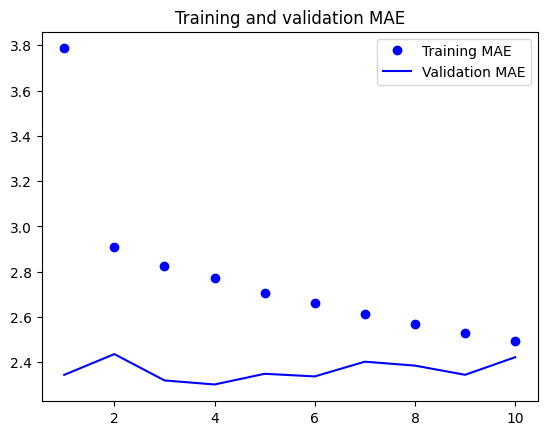

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [ ]:
# Training and evaluating a dropout-regularized, stacked GRU model for 4 epochs

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
my_model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
my_model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = my_model.fit(train_dataset,
                    epochs=4,
                    validation_data=val_dataset,
                    callbacks=callbacks)
my_model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Training MAE: {my_model.evaluate(train_dataset)[1]:.2f}")
print(f"Test MAE: {my_model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/4
819/819 [==============================] - 448s 541ms/step - loss: 24.8168 - mae: 3.6882 - val_loss: 9.5393 - val_mae: 2.3905
Epoch 2/4
819/819 [==============================] - 431s 526ms/step - loss: 14.1042 - mae: 2.9136 - val_loss: 8.9477 - val_mae: 2.3186
Epoch 3/4
819/819 [==============================] - 431s 526ms/step - loss: 13.3027 - mae: 2.8254 - val_loss: 9.5067 - val_mae: 2.4106
Epoch 4/4
819/819 [==============================] - 101s 122ms/step - loss: 9.7718 - mae: 2.4274
Training MAE: 2.43
405/405 [==============================] - 50s 123ms/step - loss: 10.2189 - mae: 2.5049
Test MAE: 2.50


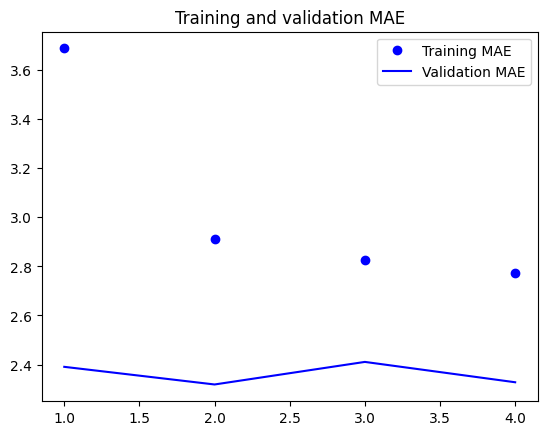

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Summary table
(Example, manually generated)

You can use the table below to show a summary of the experimental results. **Replace the Test MAE values and other contents with your own!**

| Method | Test MAE | Remarks |
| --- | --- | --- |
| Baseline | 2.62 | Silly model: "Temperature 24 hours in the future will be the same as it is now" |
| Real first model (LSTM) | 2.60| Slightly better than baseline |
| *Improved* model / variation > Dropout-regularized, stacked GRU model with 10 epochs | 2.45| Best overall, no longer overfitting |
| *Improved* model / variation > Dropout-regularized, stacked GRU model with 4 epochs | 2.50| Better than the Basline and LSTM model but suffers underfitting |

In our improved model, we tried a stack of two dropout-regularized recurrent layers. For a change, we used Gated Recurrent Unit (GRU) layers instead of LSTM. We can see that the added layer does improve the results a bit, though not dramatically. We train our model for 10 and 4 epochs and both have achieved a lower MAE score than our baseline and LSTM model.

## Part 2: Sentiment analysis using LSTMs

In Part 2 we will revisit the IMDB movie review classification task from an earlier assignment, this time using more sophisticated approaches and architectures.

Please refer to Chapter 11 of [our textbook](https://learning.oreilly.com/library/view/deep-learning-with/9781617296864) for background information on NLP and approaches for text representation in deep learning architectures.

The code (and much of the text) below is essentially from https://www.tensorflow.org/text/tutorials/text_classification_rnn  


Useful sources and references for Part 2:

- https://colab.research.google.com/github/fchollet/deep-learning-with-python-notebooks/blob/master/chapter11_part01_introduction.ipynb
- https://colab.research.google.com/github/fchollet/deep-learning-with-python-notebooks/blob/master/chapter11_part02_sequence-models.ipynb


### Imports + auxiliary function

In [ ]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

Import `matplotlib` and create a helper function to plot graphs:

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

### Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially this returns a dataset of (text, label pairs):

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"This is without doubt my favourite Le Carre novel and it is transformed to the silver screen with all the love and care one could wish for. I read a review on this site that seems to find the characters loathsome but I believe this misses the point. All Le Carre stories are essentially love stories and this is no exception. It is an accurate reflection of the period in which it is set. Betrayal is the key by everybody for the good of nobody. Pym upbringing is so close to my own that I find it chilling watching. Peter Egan is in his finest role and the late lamented Ray McAnally is unbelievably good. Even the smallest roles played by such as Andy de la Tour, Tim Healy and Jack Ellis are spot on. This cast is a Theatre Impresario's Dream. The Story should not be spoiled by ill informed description but suffice it to say it relates to a young mans slow but inexorable destruction and descent into espionage and treason. All my sympathies lie with Magnus Pym and his sole (non sexua

### Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 11,   7, 201, ...,   0,   0,   0],
       [  1, 442,   7, ...,   0,   0,   0],
       [  4,   1, 989, ...,   0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"This is without doubt my favourite Le Carre novel and it is transformed to the silver screen with all the love and care one could wish for. I read a review on this site that seems to find the characters loathsome but I believe this misses the point. All Le Carre stories are essentially love stories and this is no exception. It is an accurate reflection of the period in which it is set. Betrayal is the key by everybody for the good of nobody. Pym upbringing is so close to my own that I find it chilling watching. Peter Egan is in his finest role and the late lamented Ray McAnally is unbelievably good. Even the smallest roles played by such as Andy de la Tour, Tim Healy and Jack Ellis are spot on. This cast is a Theatre Impresario's Dream. The Story should not be spoiled by ill informed description but suffice it to say it relates to a young mans slow but inexorable destruction and descent into espionage and treason. All my sympathies lie with Magnus Pym and his sole (non sex

### Create the first model

Please refer to https://www.tensorflow.org/text/tutorials/text_classification_rnn for detailed explanation + diagram.

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 4s 4s/step
[-0.00645527]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 307ms/step
[-0.00645528]


Compile the Keras model to configure the training process:

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

### Train the model

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 793s 2s/step - loss: 0.6313 - accuracy: 0.5783 - val_loss: 0.4657 - val_accuracy: 0.7599
Epoch 2/10
391/391 [==============================] - 754s 2s/step - loss: 0.3918 - accuracy: 0.8226 - val_loss: 0.3652 - val_accuracy: 0.8438
Epoch 3/10
391/391 [==============================] - 742s 2s/step - loss: 0.3348 - accuracy: 0.8515 - val_loss: 0.3419 - val_accuracy: 0.8547
Epoch 4/10
391/391 [==============================] - 746s 2s/step - loss: 0.3172 - accuracy: 0.8616 - val_loss: 0.3310 - val_accuracy: 0.8542
Epoch 5/10
391/391 [==============================] - 766s 2s/step - loss: 0.3091 - accuracy: 0.8669 - val_loss: 0.3338 - val_accuracy: 0.8562
Epoch 6/10
391/391 [==============================] - 752s 2s/step - loss: 0.3069 - accuracy: 0.8669 - val_loss: 0.3306 - val_accuracy: 0.8552
Epoch 7/10
391/391 [==============================] - 759s 2s/step - loss: 0.3039 - accuracy: 0.8696 - val_loss: 0.3241 - val_accuracy: 0.8547

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 208s 530ms/step - loss: 0.3201 - accuracy: 0.8555
Test Loss: 0.32005003094673157
Test Accuracy: 0.8555200099945068


(0.0, 0.6480558574199676)

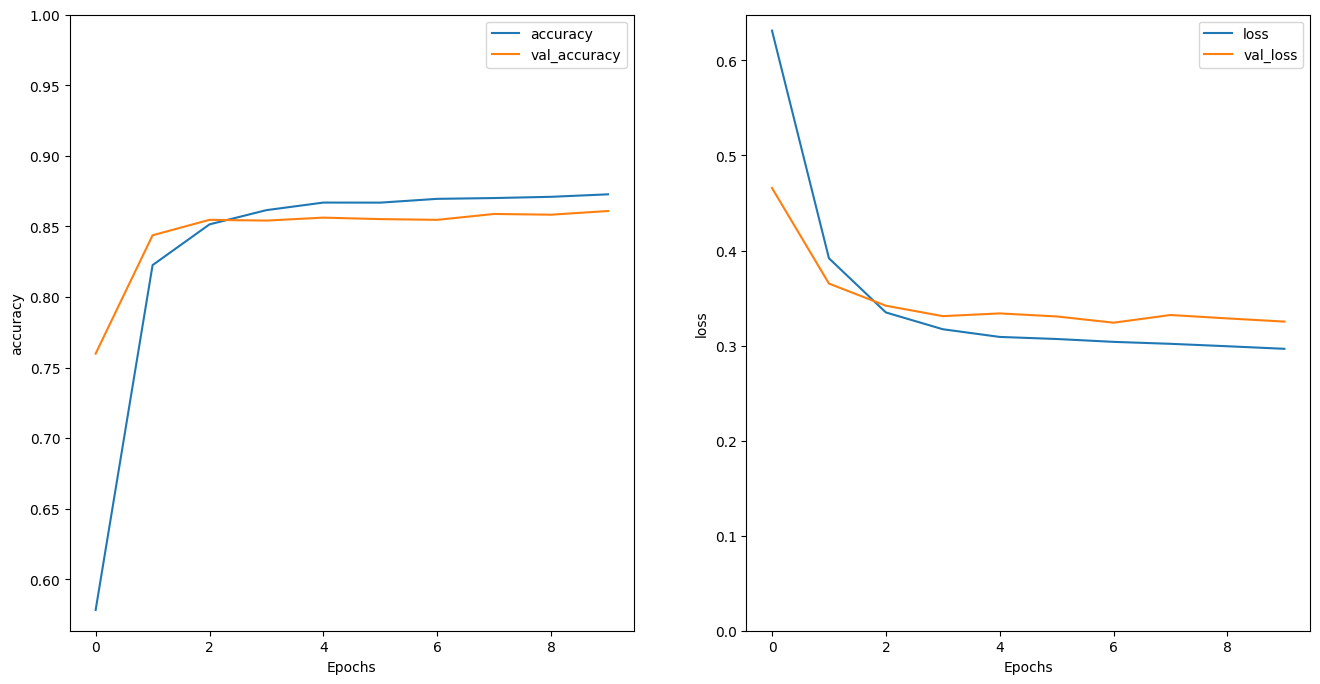

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 4s 4s/step


### Second model: stacking two LSTM layers

Please refer to https://www.tensorflow.org/text/tutorials/text_classification_rnn for additional explanation + diagram.

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 76s 159ms/step - loss: 0.5997 - accuracy: 0.6180 - val_loss: 0.4044 - val_accuracy: 0.8203
Epoch 2/10
391/391 [==============================] - 58s 146ms/step - loss: 0.3749 - accuracy: 0.8389 - val_loss: 0.3454 - val_accuracy: 0.8510
Epoch 3/10
391/391 [==============================] - 58s 148ms/step - loss: 0.3384 - accuracy: 0.8558 - val_loss: 0.3362 - val_accuracy: 0.8573
Epoch 4/10
391/391 [==============================] - 59s 149ms/step - loss: 0.3213 - accuracy: 0.8647 - val_loss: 0.3226 - val_accuracy: 0.8552
Epoch 5/10
391/391 [==============================] - 58s 148ms/step - loss: 0.3099 - accuracy: 0.8688 - val_loss: 0.3300 - val_accuracy: 0.8401
Epoch 6/10
391/391 [==============================] - 58s 147ms/step - loss: 0.3041 - accuracy: 0.8716 - val_loss: 0.3507 - val_accuracy: 0.8203
Epoch 7/10
391/391 [==============================] - 58s 147ms/step - loss: 0.3023 - accuracy: 0.8709 - val_loss: 0.3249 - val_ac

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 32s 83ms/step - loss: 0.3246 - accuracy: 0.8506
Test Loss: 0.32457563281059265
Test Accuracy: 0.850600004196167


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[-2.1777625]]


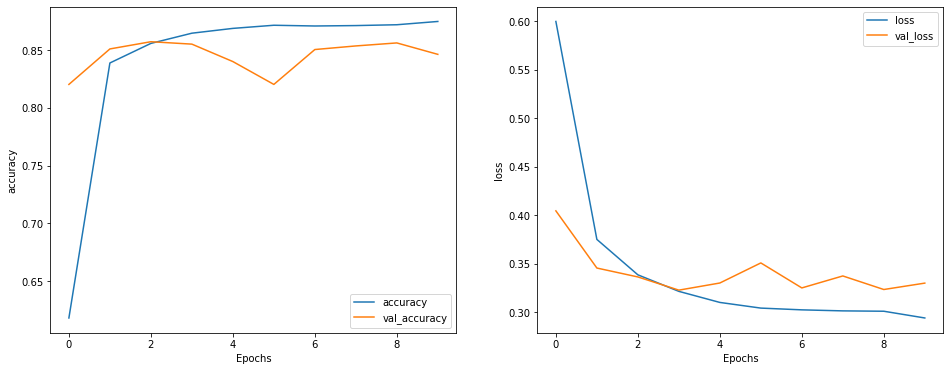

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

### TODO 2: Improve the solution for IMDB sentiment analysis
Write code to produce another solution to the movie review problem that outperforms the two solutions provided above, i.e, has a higher test accuracy.

You can use a (combination of) different architecture, dropout and/or other regularization strategies, hyperparameter optimizations, masking, pretrained embeddings, or any other acceptable "trick" in the deep learning world.

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_11 (Text  (None, 250)              0         
 Vectorization)                                                  
                                                                 
 embedding_11 (Embedding)    (None, 250, 128)          1280000   
                                                                 
 masking_4 (Masking)         (None, 250, 128)          0         
                                                                 
 conv1d_15 (Conv1D)          (None, 246, 128)          82048     
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 61, 128)          0         
 1D)                                                             
                                                                 
 conv1d_16 (Conv1D)          (None, 57, 128)         

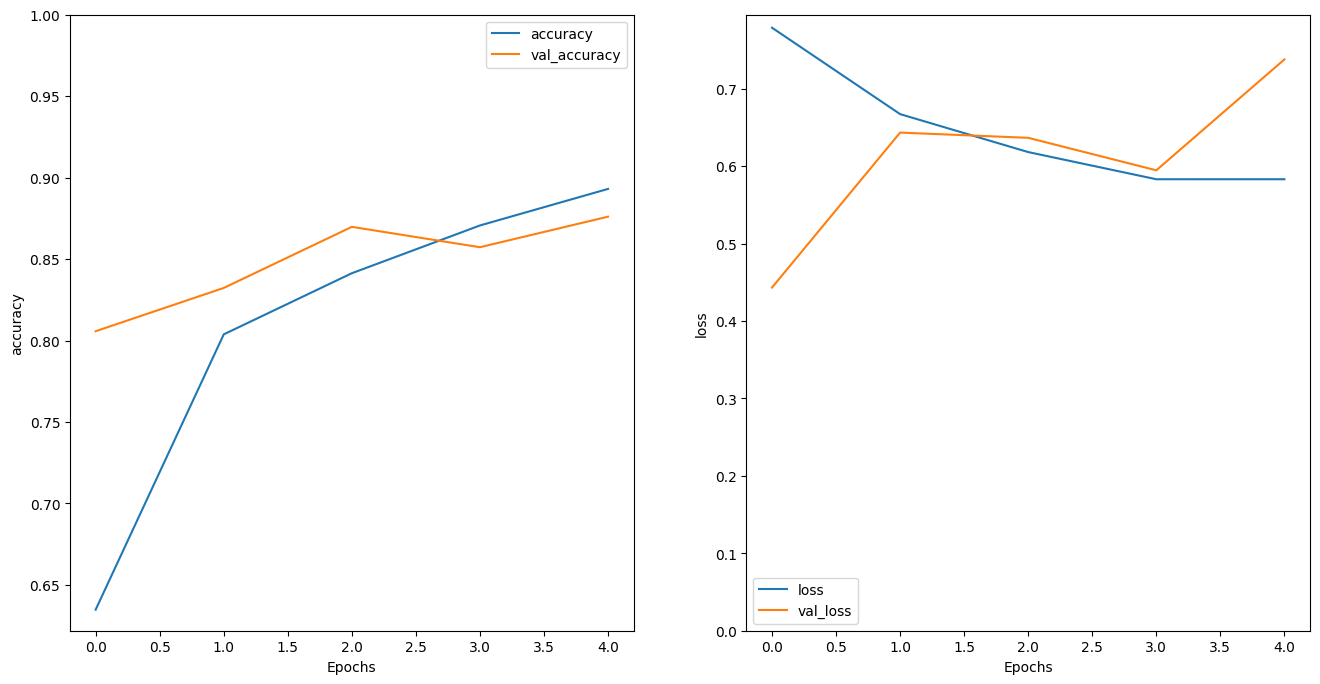

In [ ]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import RMSprop

tfds.disable_progress_bar()

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

# Load and preprocess the dataset
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

VOCAB_SIZE = 10000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE, output_sequence_length=250)
encoder.adapt(train_dataset.map(lambda text, label: text))

# Define your model architecture
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=128),
    tf.keras.layers.Masking(mask_value=0.0),  # Add Masking layer to manually apply mask
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

# Compile and train the model
optimizer = RMSprop(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_dataset, epochs=5,
                    validation_data=test_dataset,
                    validation_steps=30)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

# Plot accuracy and loss graphs
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

# Predict on a sample text
sample_text = ('The movie was great. The acting and the story were amazing. '
               'I highly recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)


### Summary table
(Example, manually generated)

You can use the table below to show a summary of the experimental results. **Replace the Test Accuracy values and other contents with your own!**

| Method | Test Accuracy | Remarks |
| --- | --- | --- |
| First model | 0.863 | Baseline |
| Second model (LSTM) | 0.852 | Slightly worse than baseline |
| *Improved* model / variation of your choice | 0.872 | Best overall but still have the sign of overfitting |


**To improve the accuracy of the model, we used these layer in our model architecture.**
1. TextVectorization layer for converting raw text into tokenized sequences and adapting to the training data
2. Embedding layer for mapping tokenized sequences to dense vectors of fixed size
3. Masking layer for masking out padding tokens to prevent them from affecting model predictions
4. Conv1D layers for applying 1D convolutional operations to learn local features from the text
5. MaxPooling1D layers for down-sampling the features
6. Bidirectional LSTM layer for capturing bidirectional temporal dependencies in the text
7. Dense layers with ReLU activation for applying fully connected operations
8. Dropout layers for regularization to prevent overfitting
9. Final Dense layer with no activation for binary classification (positive/negative sentiment)

For compiling the model, We used RMSprop optimizer with a learning rate of 0.001. The model is trained for 5 epochs.

The highest overall test accuracy of 0.872 among the three models evaluated but still presence of slight overfitting.

## Part 3: NLP using Transformers

In Part 3 we will look at the Transformer architecture and how it can be used in a specific NLP task, machine translation (from English to Spanish).

Please refer to Chapter 11 of [our textbook](https://learning.oreilly.com/library/view/deep-learning-with/9781617296864) for additional information.


Useful sources and references for Part 3:

- https://colab.research.google.com/github/fchollet/deep-learning-with-python-notebooks/blob/master/chapter11_part03_transformer.ipynb
- https://colab.research.google.com/github/fchollet/deep-learning-with-python-notebooks/blob/master/chapter11_part04_sequence-to-sequence-learning.ipynb


### Setup

In [ ]:
!wget http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
!unzip -q spa-eng.zip

--2022-07-13 16:49:29--  http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.214.128, 173.194.215.128, 173.194.216.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.214.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2638744 (2.5M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   2.52M  --.-KB/s    in 0.01s   

2022-07-13 16:49:29 (256 MB/s) - ‘spa-eng.zip’ saved [2638744/2638744]



In [ ]:
text_file = "spa-eng/spa.txt"
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    english, spanish = line.split("\t")
    spanish = "[start] " + spanish + " [end]"
    text_pairs.append((english, spanish))

In [ ]:
import random
print(random.choice(text_pairs))

('He looks a bit tired.', '[start] Parece un poco cansado. [end]')


In [ ]:
import random
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples:num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples:]

**Vectorizing the English and Spanish text pairs**

In [ ]:
import tensorflow as tf
import string
import re

from tensorflow import keras
from tensorflow.keras import layers

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

vocab_size = 15000
sequence_length = 20

source_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
target_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_english_texts = [pair[0] for pair in train_pairs]
train_spanish_texts = [pair[1] for pair in train_pairs]
source_vectorization.adapt(train_english_texts)
target_vectorization.adapt(train_spanish_texts)

**Preparing datasets for the translation task**

In [ ]:
batch_size = 64

def format_dataset(eng, spa):
    eng = source_vectorization(eng)
    spa = target_vectorization(spa)
    return ({
        "english": eng,
        "spanish": spa[:, :-1],
    }, spa[:, 1:])

def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [ ]:
for inputs, targets in train_ds.take(1):
    print(f"inputs['english'].shape: {inputs['english'].shape}")
    print(f"inputs['spanish'].shape: {inputs['spanish'].shape}")
    print(f"targets.shape: {targets.shape}")

inputs['english'].shape: (64, 20)
inputs['spanish'].shape: (64, 20)
targets.shape: (64, 20)


### The Transformer encoder

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

### The Transformer decoder

In [ ]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

### Putting it all together: A Transformer for machine translation

**PositionalEmbedding layer**

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

**End-to-end Transformer**

In [ ]:
embed_dim = 256
dense_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="english")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="spanish")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

**Training the sequence-to-sequence Transformer**

In [ ]:
transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
transformer.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
1302/1302 [==============================] - 107s 75ms/step - loss: 1.6828 - accuracy: 0.4162 - val_loss: 1.3554 - val_accuracy: 0.5100
Epoch 2/10
1302/1302 [==============================] - 97s 75ms/step - loss: 1.3418 - accuracy: 0.5313 - val_loss: 1.1639 - val_accuracy: 0.5687
Epoch 3/10
1302/1302 [==============================] - 96s 74ms/step - loss: 1.1883 - accuracy: 0.5809 - val_loss: 1.0751 - val_accuracy: 0.6026
Epoch 4/10
1302/1302 [==============================] - 96s 74ms/step - loss: 1.0982 - accuracy: 0.6129 - val_loss: 1.0403 - val_accuracy: 0.6207
Epoch 5/10
1302/1302 [==============================] - 96s 74ms/step - loss: 1.0503 - accuracy: 0.6348 - val_loss: 1.0140 - val_accuracy: 0.6333
Epoch 6/10
1302/1302 [==============================] - 96s 73ms/step - loss: 1.0193 - accuracy: 0.6501 - val_loss: 1.0066 - val_accuracy: 0.6365
Epoch 7/10
1302/1302 [==============================] - 95s 73ms/step - loss: 0.9977 - accuracy: 0.6628 - val_loss: 0.9965 

**Translating new sentences with our Transformer model**

In [ ]:
import numpy as np
spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = transformer(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(20):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))

-
Please open it.
[start] por favor [UNK] [end]
-
At first, he thought English very difficult, but now he thinks it is easy.
[start] al primera vez él pensaba que él piensa que es fácil pero él piensa que ahora es fácil [end]
-
Who is there?
[start] quién está ahí [end]
-
I'm making coffee.
[start] estoy haciendo café [end]
-
Everybody knew Tom was in trouble.
[start] todos sabía que tom estaba en problemas [end]
-
Pick me up at 2:30.
[start] [UNK] en la semana a las dos y  [end]
-
Never put off till tomorrow what you can do today.
[start] nunca te [UNK] hasta ahora que puedes hacer hoy [end]
-
I thought Tom was one of them.
[start] pensé que tom era uno de ellos [end]
-
We should obey the rules.
[start] deberíamos de la la no deberíamos de la la la la no deberíamos pasar [end]
-
You need to wear a tuxedo.
[start] necesitas que me [UNK] una [UNK] [end]
-
How much time did you spend doing research before you started writing?
[start] cuánto tiempo has hecho [UNK] la nieve antes de haber 

## Conclusions

In this project, we went through 3 different types of problems such as Temperature forecasting problem using RNNS, Sentimental analysis using LSTMs, and NLP using transformers. For the first part of our projects, we saw the baseline model and the Deep learning model for temperature forecast. Both models contain overfitting with higher MAE than the improved model we built. In our improved model, we tried a stack of two dropout-regularized recurrent layers. For a change, we used Gated Recurrent Unit (GRU) layers instead of LSTM. So we got a lower MAE score with no overfitting. In part 2, we did the sentiment analysis by using the LSTM model where our objective was to improve the accuracy of our proposed model and we got a higher accuracy. And part 3 we didn't implement any model but rather just observe the given model and the setups. This project was really fun and we learned a lot of things but it was very time-consuming to be honest. Cause each model took around 5-10 minutes to training for a single epoch. That's why we couldn't try lots of tuning that were in our thoughts.